## KPMG virtual internship

# Bikes & Cycling Accessories Organisation
- Cohort Analysis
- RFM Analysis
- Segmentation Analysis
- Prediction Modeling

#### We are provided with 4 datasets:

- Customer Demographic
- Customer Addresses
- New Customer List
- Transactions data in the past 3 months

# Import Libraries

In [638]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import missingno as msno
from textwrap import wrap
import calendar
import scipy.stats as stats
from matplotlib.gridspec import GridSpec

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("colorblind")

# suppress warnings 
import warnings
warnings.simplefilter("ignore")

In [639]:
# Read data
Combined_data = pd.read_csv('Combined_data_updated.csv')

# Recency, frequency, monetary (RFM) segmentation
- Recency: how recent was each customer’s last purchase
- Frequency: which measures how many purchases the customer has done in the last 12 months
- Montetary: measures how much has the customer spent in the last 12 months

Once we have calculated these numbers, the next step is to group them into some sort of categorization such as high, medium and low.
We can break customers into groups of equal size based on percentile values of each metric We can assign either high or low value to each metric based on a 80/20% Pareto split Or we can use existing knowledge from previous business insights about certain threshold values for each metric 

In [640]:
Combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19968 entries, 0 to 19967
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       19968 non-null  int64  
 1   product_id                           19968 non-null  int64  
 2   customer_id                          19968 non-null  int64  
 3   transaction_date                     19968 non-null  object 
 4   online_order                         19968 non-null  bool   
 5   order_status                         19968 non-null  object 
 6   brand                                19968 non-null  object 
 7   product_line                         19968 non-null  object 
 8   product_class                        19968 non-null  object 
 9   product_size                         19968 non-null  object 
 10  list_price                           19968 non-null  float64
 11  standard_cost               

In [641]:
# Convert 'transaction_id', 'product_id', 'customer_id', 'postcode' to string (object) type
Combined_data['transaction_id'] = Combined_data['transaction_id'].astype('object')
Combined_data['product_id'] = Combined_data['product_id'].astype('object')
Combined_data['customer_id'] = Combined_data['customer_id'].astype('object')
Combined_data['postcode'] = Combined_data['postcode'].astype('object')

Combined_data['transaction_date'] = pd.to_datetime(Combined_data['transaction_date'])
Combined_data['product_first_sold_date'] = pd.to_datetime(Combined_data['product_first_sold_date'])

# Recency

In [642]:
day = "2017-12-31"
day = pd.to_datetime(day)
Recency = Combined_data.groupby('customer_id').agg({"transaction_date":lambda x:((day-x.max()).days)})
Recency = Recency.loc[:, ['transaction_date']]
Recency =  Recency.rename(columns={'transaction_date': 'Recency'})
Recency.head(10)

,Recency
customer_id,
1,8
2,129
4,196
5,17
6,65
7,254
8,23
9,79
11,47


In [643]:
Combined_data = Combined_data.merge(Recency, on='customer_id', how='left')

# Frequency

In [644]:
Frequency = Combined_data.groupby('customer_id').count()
Frequency = Frequency.loc[:, ['transaction_id']]
Frequency =  Frequency.rename(columns={'transaction_id': 'Frequency'})
Frequency.head(5)

,Frequency
customer_id,
1,11
2,3
4,2
5,6
6,5


In [645]:
Combined_data = Combined_data.merge(Frequency, on='customer_id', how='left')

# Monetary

In [646]:
# Calculate the total spend ('list_price') for each 'customer_id' for approved orders.
Monetary = Combined_data.loc[Combined_data['order_status'] == 'Approved'] \
                        .groupby('customer_id') \
                        .agg({'list_price': 'sum'}) \
                        .rename(columns={'list_price': 'Monetary'})
Monetary.head()

,Monetary
customer_id,
1,9084.45
2,4149.07
4,1047.72
5,5903.20
6,5931.69


In [647]:
Combined_data = Combined_data.merge(Monetary, on='customer_id', how='left')

In [648]:
Combined_data['Monetary'].fillna(0, inplace=True)

# Calculate Percentile for RFM

In [649]:
# Recency - Recency_quartiles
# Created numbered labels
r_labels = list(range(4,0,-1))
# Divide into groups base on quartiles
Recency_quartiles = pd.qcut(Combined_data['Recency'],q=4,labels = r_labels)
# Create new columns
Combined_data['R']= Recency_quartiles
# Sort Recency values from lowest to highest
Combined_data.sort_values('Recency')

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,address,postcode,state,country,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R
17530,17559,0,3123,2017-01-10,True,Approved,OHM Cycles,Standard,high,medium,...,6915 Nobel Crossing,2195,NSW,Australia,6,0.000091,1,4,3733.72,4
1792,1794,0,993,2017-04-10,False,Approved,Norco Bicycles,Road,medium,medium,...,84019 Porter Trail,2871,NSW,Australia,3,0.000136,1,9,8086.79,4
9922,9935,0,362,2017-04-28,False,Approved,OHM Cycles,Standard,medium,medium,...,8728 Express Way,2340,NSW,Australia,7,0.000046,1,5,3486.48,4
2954,2956,54,1506,2017-09-05,False,Approved,WeareA2B,Standard,medium,medium,...,6 Canary Plaza,2223,NSW,Australia,8,0.001279,1,10,11058.14,4
511,513,0,1052,2017-11-29,False,Approved,Trek Bicycles,Road,medium,medium,...,06 Declaration Hill,3184,VIC,Australia,11,0.000133,1,6,8478.41,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13807,13826,41,2876,2017-02-08,True,Approved,Norco Bicycles,Standard,low,medium,...,7 Bartillon Junction,2044,NSW,Australia,10,0.000210,326,1,958.74,1
5373,5379,25,822,2017-02-05,False,Approved,OHM Cycles,Standard,high,medium,...,659 Scofield Street,3175,VIC,Australia,5,0.000802,329,1,2005.66,1
8752,8765,35,1544,2017-02-04,True,Approved,Trek Bicycles,Standard,low,medium,...,16 Maple Wood Center,2155,NSW,Australia,10,0.000903,330,1,1057.51,1
7255,7263,45,1846,2017-01-31,False,Approved,Solex,Standard,medium,medium,...,8 Hoffman Alley,3181,VIC,Australia,10,0.000356,334,1,441.49,1


In [650]:
# Frequency - Frequency Quartile
Frequency_quartiles = pd.qcut(Combined_data['Frequency'],q=4,labels = range(1,5))
Combined_data ['F']=Frequency_quartiles
Combined_data.sort_values('Frequency')

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,postcode,state,country,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R,F
13691,13710,59,2749,2017-11-26,False,Approved,Solex,Standard,medium,large,...,2196,NSW,Australia,10,0.000328,35,1,1061.56,3,1
14535,14554,54,2352,2017-11-24,True,Approved,WeareA2B,Standard,medium,medium,...,3194,VIC,Australia,10,0.001279,37,1,1292.84,3,1
2238,2240,100,1203,2017-12-23,True,Approved,Norco Bicycles,Road,medium,medium,...,4017,QLD,Australia,6,0.000830,8,1,1036.59,4,1
7255,7263,45,1846,2017-01-31,False,Approved,Solex,Standard,medium,medium,...,3181,VIC,Australia,10,0.000356,334,1,441.49,1,1
7197,7205,0,1325,2017-10-09,True,Approved,Solex,Road,medium,medium,...,4019,QLD,Australia,4,0.000104,83,1,416.98,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,8005,0,2476,2017-11-17,False,Approved,WeareA2B,Standard,medium,small,...,4118,QLD,Australia,5,0.000044,15,14,14578.69,4,4
12190,12207,80,2476,2017-12-16,True,Approved,Trek Bicycles,Standard,medium,large,...,4118,QLD,Australia,5,0.000873,15,14,14578.69,4,4
7900,7910,90,2476,2017-10-28,True,Approved,Solex,Standard,low,medium,...,4118,QLD,Australia,5,0.000437,15,14,14578.69,4,4
4433,4437,99,1068,2017-11-07,True,Approved,OHM Cycles,Standard,medium,medium,...,2170,NSW,Australia,8,0.000456,5,14,14254.55,4,4


In [651]:
# Monetary - Spent Quartile
# Created numbered labels, Divide into groups base on quartiles
Monetary_quartiles = pd.qcut(Combined_data['Monetary'],q=4,labels = range(1,5))
# Create new columns
Combined_data ['M']=Monetary_quartiles
# Sort Recency values from lowest to highest
Combined_data.sort_values('Monetary')

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,state,country,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R,F,M
6791,6799,83,287,2017-08-14,True,Cancelled,Solex,Touring,medium,large,...,NSW,Australia,8,0.001409,139,1,0.00,1,1,1
1629,1631,22,3292,2017-03-04,True,Approved,WeareA2B,Standard,medium,medium,...,NSW,Australia,10,0.000015,302,1,60.34,1,1,1
6525,6533,2,2532,2017-08-12,False,Approved,Solex,Standard,medium,medium,...,NSW,Australia,11,0.000018,141,1,71.49,1,1,1
5897,5904,2,2274,2017-08-15,True,Approved,Solex,Standard,medium,medium,...,NSW,Australia,10,0.000018,56,2,142.98,2,1,1
16588,16612,2,2274,2017-11-05,True,Approved,Solex,Standard,medium,medium,...,NSW,Australia,10,0.000018,56,2,142.98,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5657,5664,8,2183,2017-10-08,True,Approved,Solex,Road,medium,small,...,QLD,Australia,4,0.000187,9,14,19071.32,4,4,4
18922,18954,28,2183,2017-10-20,False,Approved,Norco Bicycles,Standard,medium,small,...,QLD,Australia,4,0.000134,9,14,19071.32,4,4,4
132,134,78,2183,2017-05-09,False,Approved,Giant Bicycles,Standard,medium,large,...,QLD,Australia,4,0.001056,9,14,19071.32,4,4,4
9764,9777,31,2183,2017-12-22,False,Approved,Giant Bicycles,Standard,medium,medium,...,QLD,Australia,4,0.000058,9,14,19071.32,4,4,4


In [652]:
# Build RFM segment and RFM scores
def join_rfm(x):return str(x['R'])+ str(x['F'])+ str(x['M'])
Combined_data['RFM Segment']=Combined_data.apply(join_rfm,axis =1)
Combined_data['RFM Scores']=Combined_data[['R','F','M']].sum(axis=1)
Combined_data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R,F,M,RFM Segment,RFM Scores
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,6,0.000018,76,3,1953.15,1,1,1,111,3
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,5,0.001703,21,7,7351.70,3,2,3,323,8
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,1,0.001545,57,6,8148.22,2,2,3,223,7
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,10,0.000817,122,7,7539.81,1,2,3,123,6
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,7,0.001056,76,10,11292.54,1,4,4,144,9


In [653]:
Combined_data.groupby('RFM Segment').size().sort_values(ascending=False)[:10]

RFM Segment
111    1675
444    1256
344     997
211     947
311     823
223     804
112     743
411     692
222     664
322     659
dtype: int64

As we can see , the lowest RFM segment (111) and the highest RFM segment (444) are top 2 segments 

In [654]:
# Filtering on RFM segments
Combined_data[Combined_data['RFM Segment']=='111'][:5]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R,F,M,RFM Segment,RFM Scores
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,6,0.000018,76,3,1953.15,1,1,1,111,3
8,9,67,1305,2017-08-10,False,Approved,Solex,Standard,medium,large,...,4,0.000690,143,5,4862.79,1,1,1,111,3
21,22,37,595,2017-06-29,True,Approved,OHM Cycles,Standard,low,medium,...,4,0.001545,185,3,3268.42,1,1,1,111,3
26,27,64,2666,2017-04-11,True,Approved,Trek Bicycles,Standard,medium,large,...,8,0.000873,257,4,4534.90,1,1,1,111,3
29,30,91,1173,2017-03-15,False,Approved,WeareA2B,Standard,low,medium,...,7,0.000128,109,3,2042.97,1,1,1,111,3


In [655]:
Combined_data[Combined_data['RFM Segment']=='444'][:5]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,R,F,M,RFM Segment,RFM Scores
9,10,12,3262,2017-08-30,True,Approved,WeareA2B,Standard,medium,medium,...,8,0.001070,2,10,9899.64,4,4,4,444,12
23,24,82,515,2017-10-18,False,Approved,Giant Bicycles,Road,medium,medium,...,12,0.000709,15,9,12264.80,4,4,4,444,12
43,44,46,165,2017-12-22,False,Approved,Solex,Standard,low,medium,...,10,0.001215,9,9,9893.75,4,4,4,444,12
62,63,35,368,2017-12-17,False,Approved,Giant Bicycles,Standard,medium,medium,...,6,0.000449,14,9,9300.06,4,4,4,444,12
73,74,56,1506,2017-01-21,True,Approved,OHM Cycles,Standard,medium,medium,...,8,0.000046,1,10,11058.14,4,4,4,444,12


In [656]:
# Summary Metrics per RFM Score
RFM_summary = Combined_data.groupby('RFM Scores').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
RFM_summary

Recency Frequency Monetary      
              mean      mean     mean count
RFM Scores                                 
3            140.1       3.5   3413.8  1675
4             90.3       4.4   4648.8  1877
5             65.7       5.1   5147.8  2185
6             52.1       5.5   5843.5  2721
7             43.3       6.4   6992.2  2696
8             34.6       7.0   7721.5  2161
9             38.5       8.0   8928.3  2072
10            31.1       8.9  10275.0  1739
11            20.2       9.7  11187.1  1586
12             8.1      10.3  11832.9  1256

In [657]:
# Grouping into named Segments - Use RFM Score to group customers into High Value, Medium Value, and Low Value Segments
def segment_customer (Combined_data):
    if Combined_data['RFM Scores']>=9:
        return 'High Value'
    elif (Combined_data['RFM Scores']>6 ) and (Combined_data['RFM Scores']<9):
        return 'Medium Value'
    else:
        return 'Low Value'

Combined_data['Customer_group']=Combined_data.apply(segment_customer,axis=1)

Combined_data.groupby('Customer_group').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)


Recency Frequency Monetary      
                  mean      mean     mean count
Customer_group                                 
High Value        26.5       9.1  10367.1  6653
Low Value         81.5       4.8   4917.5  8458
Medium Value      39.5       6.7   7316.7  4857

In [ ]:
# Calculate the counts for each group
group_counts = Combined_data['Customer_group'].value_counts()

# Calculate the percentages for each group
group_percentages = (group_counts / group_counts.sum() * 100).round(2)

# Map the percentages back to the original DataFrame
Combined_data['Group_Percentage'] = Combined_data['Customer_group'].map(group_percentages)

# Add the '%' symbol
Combined_data['Group_Percentage'] = Combined_data['Group_Percentage'].astype(str) + '%'

# Show the DataFrame with the new column
Combined_data.head()

In [658]:
Combined_data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,Profit_M_AUD,Recency,Frequency,Monetary,R,F,M,RFM Segment,RFM Scores,Customer_group
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,0.000018,76,3,1953.15,1,1,1,111,3,Low Value
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,0.001703,21,7,7351.70,3,2,3,323,8,Medium Value
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,0.001545,57,6,8148.22,2,2,3,223,7,Medium Value
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,0.000817,122,7,7539.81,1,2,3,123,6,Low Value
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,0.001056,76,10,11292.54,1,4,4,144,9,High Value


# EDA

In [659]:
Combined_data.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'Profit', 'Transaction_year',
       'Transaction_month', 'Transaction_day', 'day_of_the_week', 'name',
       'gender', 'past_3_years_bike_related_purchases', 'DOB', 'age',
       'job_title', 'job_industry_category', 'wealth_segment', 'age_group',
       'deceased_indicator', 'owns_car', 'tenure', 'address', 'postcode',
       'state', 'country', 'property_valuation', 'Profit_M_AUD', 'Recency',
       'Frequency', 'Monetary', 'R', 'F', 'M', 'RFM Segment', 'RFM Scores',
       'Customer_group'],
      dtype='object')

In [660]:
# Select numerical data types first
numerical_subset = Combined_data.select_dtypes(include=['number'])

# Now, exclude the specific columns
numerical_subset = numerical_subset.drop(columns=['Transaction_year', 'Transaction_month', 'Transaction_day'])

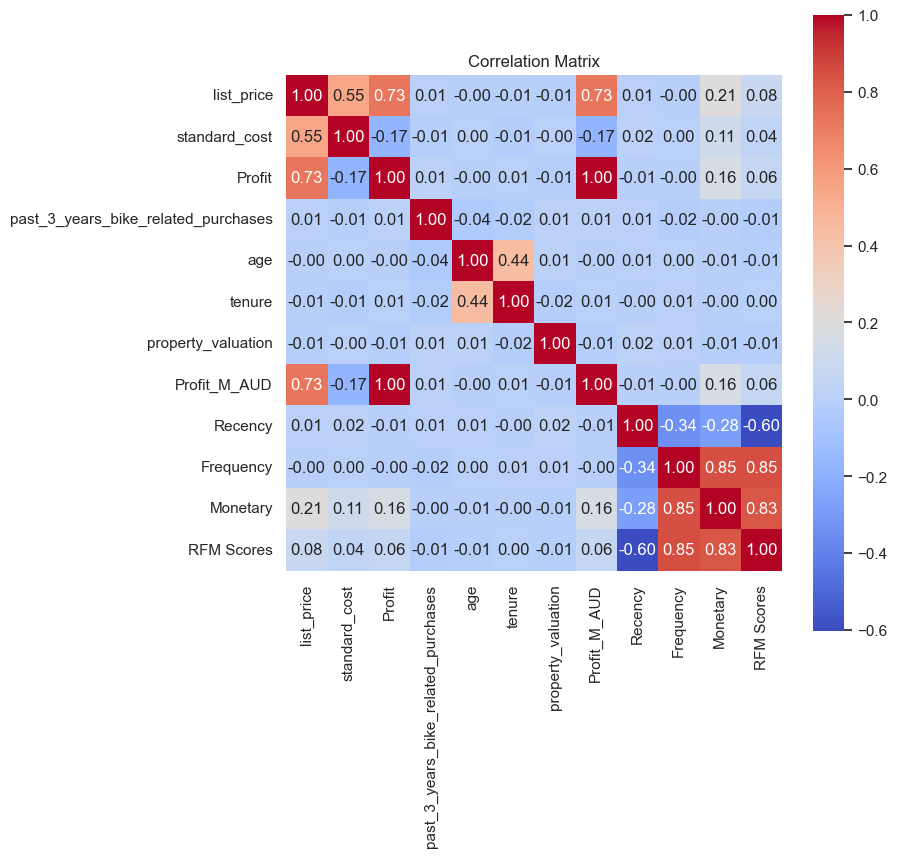

In [661]:
# Heatmap
# Calculate the correlation matrix
corr_matrix = numerical_subset.corr()

# Set the size of the matplotlib canvas
plt.figure(figsize=(8, 8))  # You can adjust the size as needed

# Create the heatmap
sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', cmap='coolwarm')

# Set the title of the heatmap
plt.title('Correlation Matrix')

# Show the plot
plt.show()


# Interpretation:
- Moderately positive correlation (0.55), indicating that items with higher list prices tend to have higher standard costs.
- Strong positive correlation (0.73), suggesting that higher list prices are often associated with higher profits.
-  Slight negative correlation (-0.17), implying that increased costs could potentially lower profits, if not matched by an increase in list price.
- Moderate negative correlation (-0.34), which could mean that more recently active customers may make purchases more frequently.
- Very strong positive correlation (0.85), indicating that customers who purchase more frequently also tend to spend more in total.

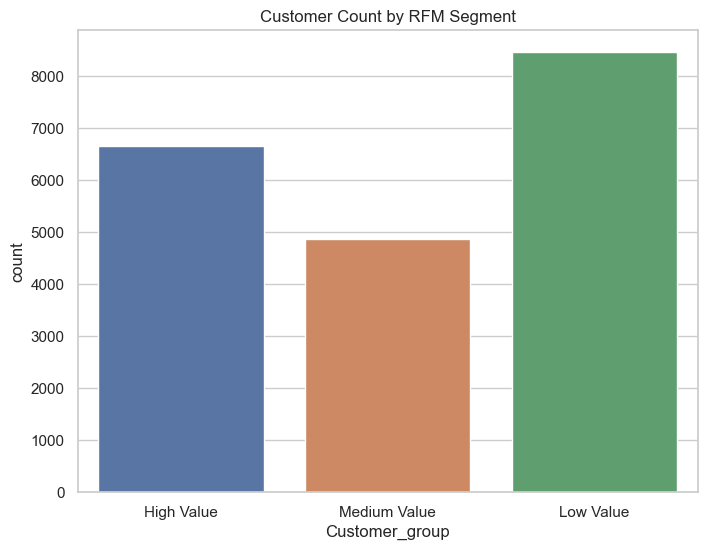

In [664]:
# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Customer_group', data=Combined_data, order=['High Value', 'Medium Value', 'Low Value'])
plt.title('Customer Count by RFM Segment')
plt.show()

The bar chart indicates that the 'Low Value' RFM segment comprises the largest group of customers, with 'High Value' and 'Medium Value' segments following, suggesting a potential focus area for improving customer value and retention strategies.

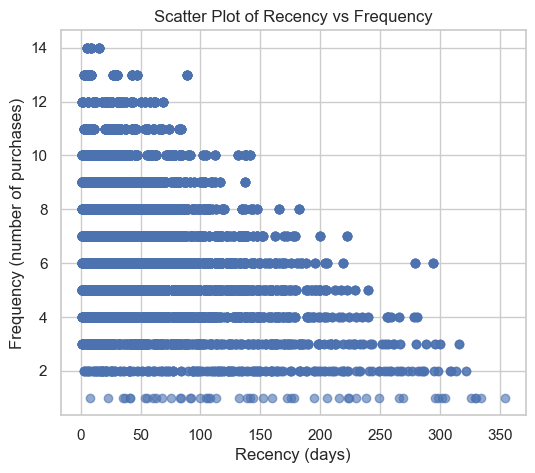

In [665]:
# Scatter plot for Recency and Frequency
plt.figure(figsize=(6, 5))
plt.scatter(Combined_data['Recency'], Combined_data['Frequency'], alpha=0.6)
plt.title('Scatter Plot of Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (number of purchases)')
plt.grid(True)
plt.show()


- Frequency for most customers seems to hover at the lower end of the scale, suggesting that while purchases are made, they are not exceedingly frequent.
- There is a concentration of customers with higher frequencies despite higher recency values, which might indicate occasional bulk purchasing or seasonal buying patterns.

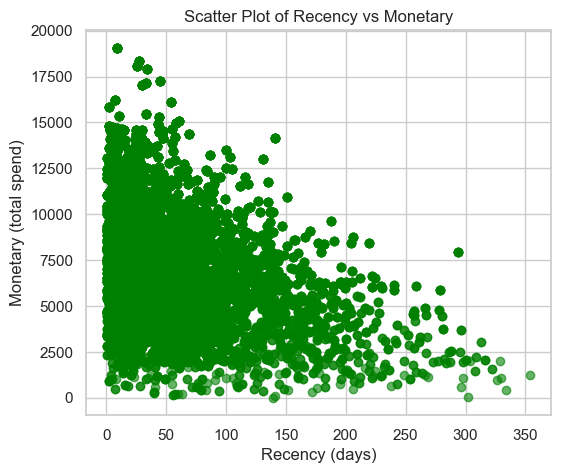

In [666]:
# Scatter plot for Recency and Monetary
plt.figure(figsize=(6, 5))
plt.scatter(Combined_data['Recency'], Combined_data['Monetary'], alpha=0.6, color='green')
plt.title('Scatter Plot of Recency vs Monetary')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (total spend)')
plt.grid(True)
plt.show()

- The spread of customers shows that higher monetary values are not necessarily associated with more recent interactions, indicating that some of the most valuable customers may not have made recent purchases.
- There's a wide distribution of monetary values among customers with low recency, which might suggest that recent promotions or sales could be effective at various spending levels.

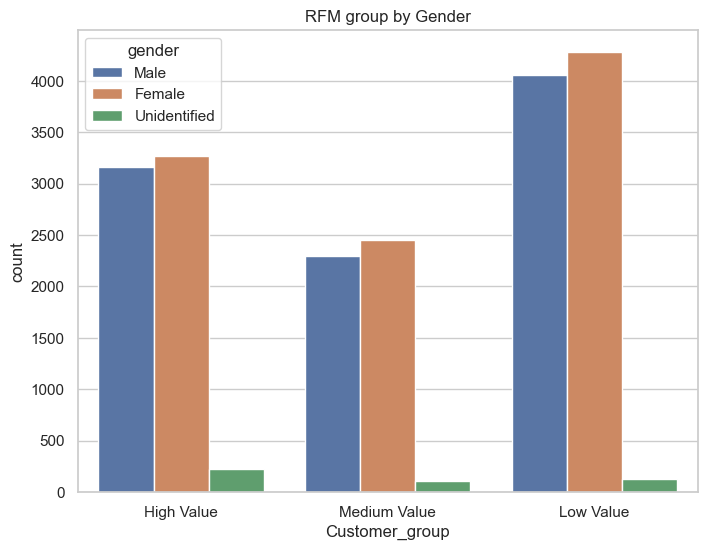

In [669]:
# RFM Segment by Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Customer_group', hue='gender', data=Combined_data, order=['High Value', 'Medium Value', 'Low Value'])
plt.title('RFM group by Gender')
plt.show()

- Males are the predominant gender in each RFM segment, with their numbers slightly higher than females across 'High Value', 'Medium Value', and 'Low Value' segments.
- The 'Low Value' segment has the highest overall count of customers across all genders.
- The count of unidentified genders is significantly lower in comparison to identified genders across all segments.

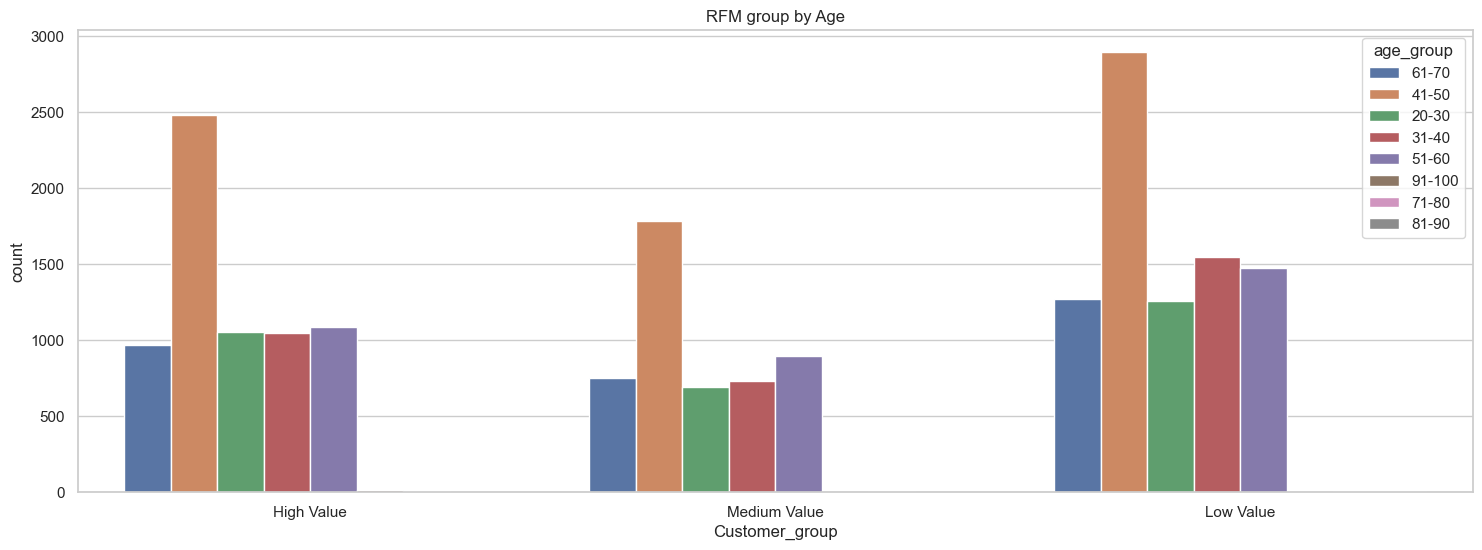

In [670]:
# RFM Segment by Age
# This assumes an 'age_group' column exists.
plt.figure(figsize=(18, 6))
sns.countplot(x='Customer_group', hue='age_group', data=Combined_data, order=['High Value', 'Medium Value', 'Low Value'])
plt.title('RFM group by Age')
plt.show()

- The age group 41-50 is the most represented in all RFM segments.
- The 'High Value' segment shows a more balanced distribution across different age groups.
- There is a noticeable decrease in representation as the age groups increase from 51 onwards, particularly in the 'High Value' and 'Medium Value' segments.

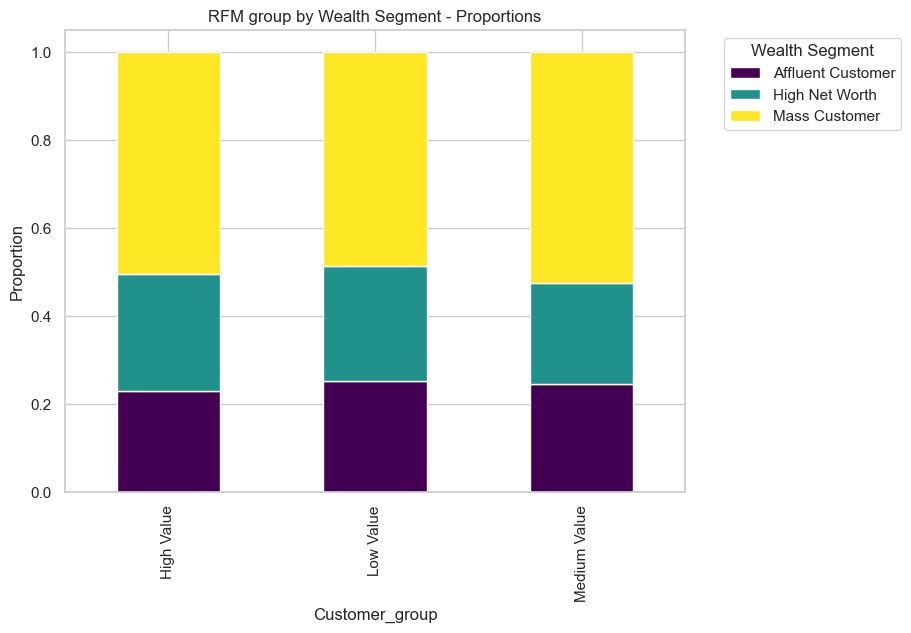

In [671]:
# RFM Segment by Wealth Segment
# Create a cross-tabulation of counts
ctab = pd.crosstab(Combined_data['Customer_group'], Combined_data['wealth_segment'])

# Normalize the crosstab to get proportions
ctab_prop = ctab.div(ctab.sum(1), axis=0)

# Plot stacked bar chart
ctab_prop.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
plt.title('RFM group by Wealth Segment - Proportions')
plt.xlabel('Customer_group')
plt.ylabel('Proportion')
plt.legend(title='Wealth Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- The 'Mass Customer' category is the most substantial portion within each RFM segment.
- 'Affluent Customer' and 'High Net Worth' categories are relatively less represented, with 'High Net Worth' being the smallest group in each segment.

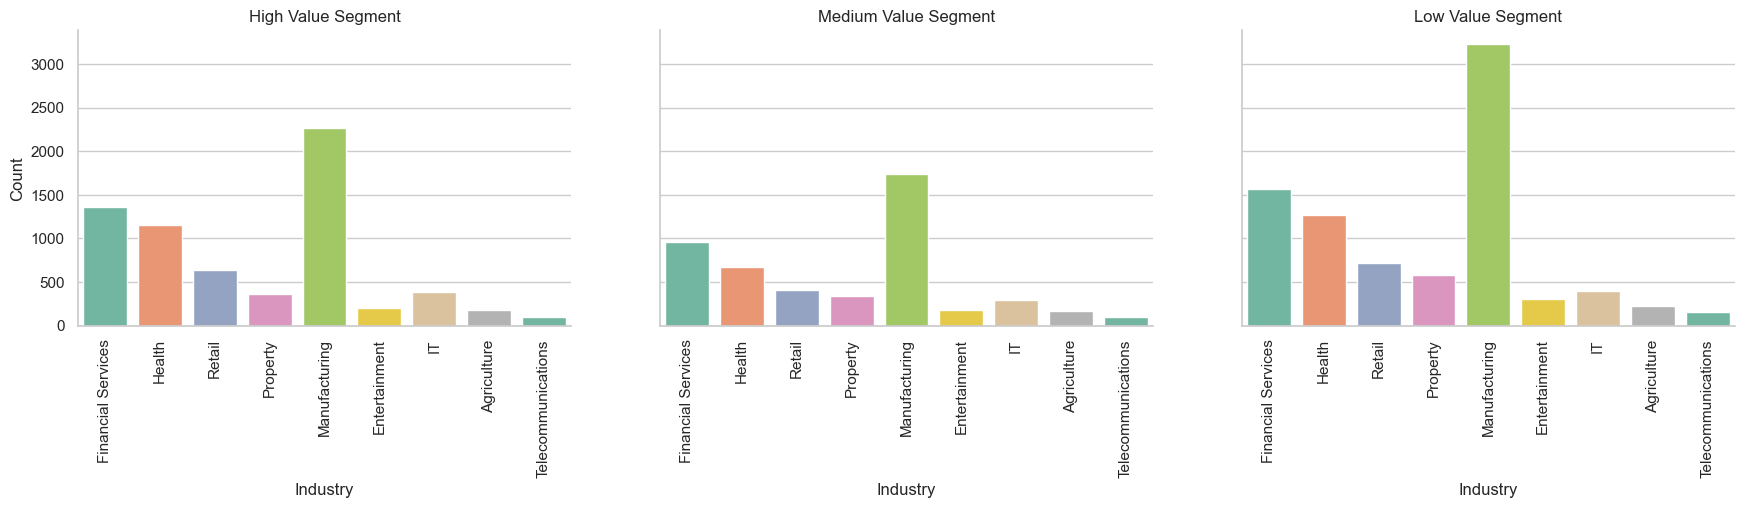

In [672]:
# RFM Segment by Industry
# Facet grid of bar plots for RFM segment by industry
g = sns.catplot(
    x='job_industry_category', 
    col='Customer_group', 
    col_order=['High Value', 'Medium Value', 'Low Value'],
    data=Combined_data, 
    kind='count', 
    height=4, 
    aspect=1.5, 
    palette='Set2'
)
g.set_xticklabels(rotation=90)
g.set_titles("{col_name} Segment")
g.set_axis_labels("Industry", "Count")
plt.show()


- The 'Manufacturing' industry has the highest number of customers in all RFM segments.
- 'Financial Services' and 'Health' industries also have a significant presence in each segment.
- The 'Agriculture' and 'Telecommunications' industries are the least represented in the RFM segments.

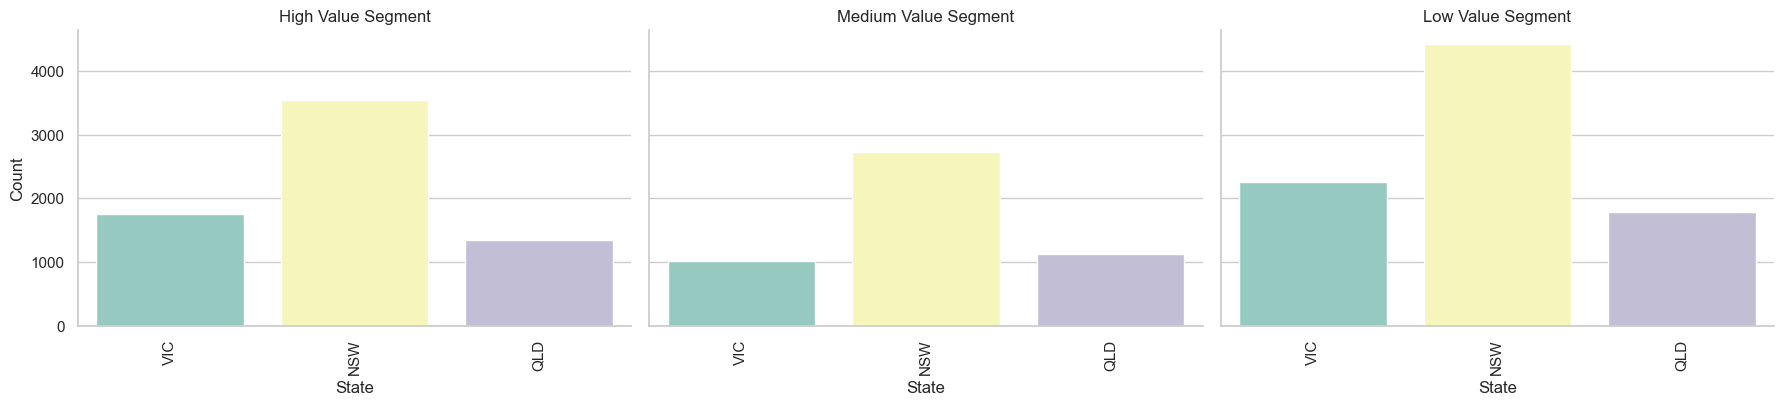

In [673]:
# RFM Segment by state
# Facet grid of bar plots for RFM segment by state
g = sns.catplot(
    x='state', 
    col='Customer_group', 
    col_order=['High Value', 'Medium Value', 'Low Value'],
    data=Combined_data, 
    kind='count', 
    height=4, 
    aspect=1.5, 
    palette='Set3'
)
g.set_xticklabels(rotation=90)
g.set_titles("{col_name} Segment")
g.set_axis_labels("State", "Count")
plt.show()


- 'NSW' and 'VIC' are the most represented states in the all segments.

In [674]:
Combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19968 non-null  object        
 1   product_id                           19968 non-null  object        
 2   customer_id                          19968 non-null  object        
 3   transaction_date                     19968 non-null  datetime64[ns]
 4   online_order                         19968 non-null  bool          
 5   order_status                         19968 non-null  object        
 6   brand                                19968 non-null  object        
 7   product_line                         19968 non-null  object        
 8   product_class                        19968 non-null  object        
 9   product_size                         19968 non-null  object        
 10  list_price

In [676]:
# Create a subset for k-means clustering by dropping specified columns
kmeans_df = Combined_data.drop(columns=[
    'transaction_id', 'product_id', 'order_status','list_price', 'standard_cost', 'product_first_sold_date',
    'Profit', 'transaction_date', 'Transaction_year', 'Transaction_month', 'Transaction_day',
    'day_of_the_week', 'name', 'DOB', 'age_group', 'deceased_indicator', 'address', 'postcode',
    'country', 'Profit_M_AUD', 'R', 'F', 'M', 'RFM Segment','Customer_group'
])

# Display the first few rows of the new subset to verify
kmeans_df.head()

,customer_id,online_order,brand,product_line,product_class,product_size,gender,past_3_years_bike_related_purchases,age,job_title,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,Recency,Frequency,Monetary,RFM Scores
0,2950,False,Solex,Standard,medium,medium,Male,19.0,68,Software Engineer I,Financial Services,Mass Customer,Yes,10,VIC,6,76,3,1953.15,3
1,3120,True,Trek Bicycles,Standard,medium,large,Female,89.0,44,Clinical Specialist,Health,Mass Customer,Yes,10,NSW,5,21,7,7351.70,8
2,402,False,OHM Cycles,Standard,low,medium,Male,9.0,46,Desktop Support Technician,Retail,Affluent Customer,No,22,NSW,1,57,6,8148.22,7
3,3135,False,Norco Bicycles,Standard,medium,medium,Male,83.0,61,Staff Scientist,Financial Services,Mass Customer,No,16,NSW,10,122,7,7539.81,6
4,787,True,Giant Bicycles,Standard,medium,large,Female,29.0,27,Business Systems Development Analyst,Retail,Affluent Customer,Yes,2,NSW,7,76,10,11292.54,9


# K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation.

# K-means gives the best result under the following conditions:

- Symmetric distribution of variables (Data’s distribution is not skewed )
- Data is standardised (variables with same average value and variance).

In [677]:
Combined_data.describe()

,list_price,standard_cost,Profit,Transaction_year,Transaction_month,Transaction_day,past_3_years_bike_related_purchases,age,tenure,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,RFM Scores
count,19968.000000,19968.00000,19968.000000,19968.0,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000
mean,1107.780004,554.45852,553.321484,2017.0,6.517027,15.578325,48.757412,45.873748,10.666717,7.516376,0.000553,52.936649,6.668470,7316.786896,7.236579
std,582.852548,404.31361,494.615147,0.0,3.449238,8.674961,28.611359,12.475686,5.611801,2.824783,0.000495,49.279326,2.334857,3007.991078,2.618575
min,12.010000,7.21000,-372.840000,2017.0,1.000000,1.000000,0.000000,21.000000,1.000000,1.000000,-0.000373,1.000000,1.000000,0.000000,3.000000
25%,575.270000,215.14000,133.780000,2017.0,4.000000,8.000000,24.000000,37.000000,6.000000,6.000000,0.000134,16.000000,5.000000,5117.100000,5.000000
50%,1163.890000,464.72000,445.210000,2017.0,7.000000,16.000000,48.000000,46.000000,10.000000,8.000000,0.000445,39.000000,7.000000,7017.550000,7.000000
75%,1635.300000,795.10000,830.240000,2017.0,10.000000,23.000000,73.000000,55.000000,15.000000,10.000000,0.000830,75.000000,8.000000,9202.850000,9.000000
max,2091.470000,1759.85000,1702.550000,2017.0,12.000000,31.000000,99.000000,92.000000,22.000000,12.000000,0.001703,354.000000,14.000000,19071.320000,12.000000


In [678]:
# Print the average values of the variables in the dataset
print(Combined_data.mean())


transaction_id                         9997.846504
product_id                               45.365986
customer_id                            1740.254307
online_order                              0.509665
list_price                             1107.780004
standard_cost                           554.458520
Profit                                  553.321484
Transaction_year                       2017.000000
Transaction_month                         6.517027
Transaction_day                          15.578325
past_3_years_bike_related_purchases      48.757412
age                                      45.873748
tenure                                   10.666717
postcode                               2987.623347
property_valuation                        7.516376
Profit_M_AUD                              0.000553
Recency                                  52.936649
Frequency                                 6.668470
Monetary                               7316.786896
RFM Segment                    

In [679]:
# Print the standard deviation of the variables in the dataset
print(Combined_data.std())


transaction_id                                          5773.929973
product_id                                                30.750115
customer_id                                             1009.819066
transaction_date                        105 days 08:57:29.659100958
online_order                                               0.499919
list_price                                               582.852548
standard_cost                                             404.31361
product_first_sold_date                2892 days 03:39:14.968490912
Profit                                                   494.615147
Transaction_year                                                0.0
Transaction_month                                          3.449238
Transaction_day                                            8.674961
past_3_years_bike_related_purchases                       28.611359
age                                                       12.475686
tenure                                          

In [680]:
Combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19968 non-null  object        
 1   product_id                           19968 non-null  object        
 2   customer_id                          19968 non-null  object        
 3   transaction_date                     19968 non-null  datetime64[ns]
 4   online_order                         19968 non-null  bool          
 5   order_status                         19968 non-null  object        
 6   brand                                19968 non-null  object        
 7   product_line                         19968 non-null  object        
 8   product_class                        19968 non-null  object        
 9   product_size                         19968 non-null  object        
 10  list_price

In [681]:
Combined_data.describe()

,list_price,standard_cost,Profit,Transaction_year,Transaction_month,Transaction_day,past_3_years_bike_related_purchases,age,tenure,property_valuation,Profit_M_AUD,Recency,Frequency,Monetary,RFM Scores
count,19968.000000,19968.00000,19968.000000,19968.0,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000
mean,1107.780004,554.45852,553.321484,2017.0,6.517027,15.578325,48.757412,45.873748,10.666717,7.516376,0.000553,52.936649,6.668470,7316.786896,7.236579
std,582.852548,404.31361,494.615147,0.0,3.449238,8.674961,28.611359,12.475686,5.611801,2.824783,0.000495,49.279326,2.334857,3007.991078,2.618575
min,12.010000,7.21000,-372.840000,2017.0,1.000000,1.000000,0.000000,21.000000,1.000000,1.000000,-0.000373,1.000000,1.000000,0.000000,3.000000
25%,575.270000,215.14000,133.780000,2017.0,4.000000,8.000000,24.000000,37.000000,6.000000,6.000000,0.000134,16.000000,5.000000,5117.100000,5.000000
50%,1163.890000,464.72000,445.210000,2017.0,7.000000,16.000000,48.000000,46.000000,10.000000,8.000000,0.000445,39.000000,7.000000,7017.550000,7.000000
75%,1635.300000,795.10000,830.240000,2017.0,10.000000,23.000000,73.000000,55.000000,15.000000,10.000000,0.000830,75.000000,8.000000,9202.850000,9.000000
max,2091.470000,1759.85000,1702.550000,2017.0,12.000000,31.000000,99.000000,92.000000,22.000000,12.000000,0.001703,354.000000,14.000000,19071.320000,12.000000


In [682]:
# Define the function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], kde=True)
    print("{}'s Skew: {}\nSkew Test Result: {}".format(column, skew, skewtest))
    return

Recency's Skew: 1.6410028567202213
Skew Test Result: SkewtestResult(statistic=68.24566463000592, pvalue=0.0)
Frequency's Skew: 0.3487610096117155
Skew Test Result: SkewtestResult(statistic=19.56110584711637, pvalue=3.318028518325854e-85)
Monetary's Skew: 0.47585047475056014
Skew Test Result: SkewtestResult(statistic=26.106805810396033, pvalue=3.0515811881691676e-150)


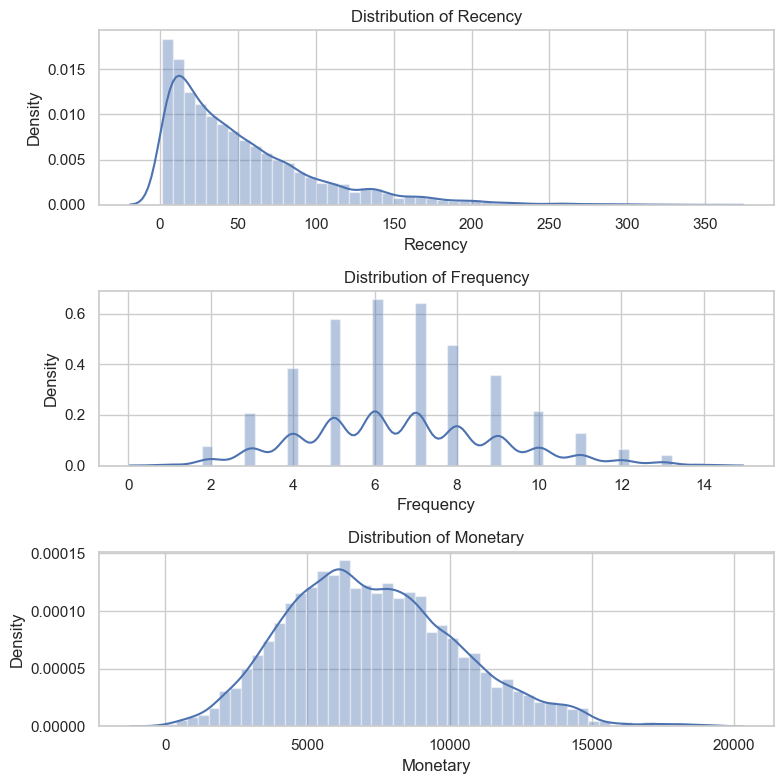

In [683]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(8, 8))

# Assuming RFM_Table is a DataFrame created from the Combined_data with the necessary RFM columns
# You might need to adjust this part to fit your data structure
RFM_Table = Combined_data[['Recency', 'Frequency', 'Monetary']]

plt.subplot(3, 1, 1)
check_skew(RFM_Table, 'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table, 'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table, 'Monetary')

plt.tight_layout()
plt.show()

As you can see, the Recency metric has a tail on the right, so we can conclude that it is skewed

# We have to transform the data, so it has a more symmetrical form. There are some methods that we can use to manage the skewness:

-log transformation
-square root transformation
-box-cox transformation Note: We can use the transformation if and only if the variable only has positive values.

(The easiest way to unskew the data is applying a logarithmic transformation, but this only works on positive values. There are other approaches like a Box-Cox transformation, but we will use the simpler version for this example. We first import the NumPy library as np and then apply the log() function on the Recency variable. We store it as Recency_log. )

In [685]:
# List of columns to keep
columns_to_keep = [
    'customer_id', 'Recency', 'Frequency', 'Monetary', 
    'R', 'F', 'M', 'RFM Segment', 'RFM Scores', 'Customer_group'
]

# Creating the new DataFrame with selected columns
RFM_cluster = Combined_data[columns_to_keep]

# Displaying information about the new DataFrame to confirm successful creation
RFM_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     19968 non-null  object  
 1   Recency         19968 non-null  int64   
 2   Frequency       19968 non-null  int64   
 3   Monetary        19968 non-null  float64 
 4   R               19968 non-null  category
 5   F               19968 non-null  category
 6   M               19968 non-null  category
 7   RFM Segment     19968 non-null  object  
 8   RFM Scores      19968 non-null  int64   
 9   Customer_group  19968 non-null  object  
dtypes: category(3), float64(1), int64(3), object(3)
memory usage: 1.3+ MB


In [686]:
#Log Transformation
RFM_columns = RFM_cluster[['Recency', 'Frequency', 'Monetary']]

In [687]:
def analyze_skewness(df, x):
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    sns.histplot(df[x], kde=True, ax=ax[0,0])
    ax[0,0].set_title('Original ' + x)
    sns.histplot(np.log(df[x]+1), kde=True, ax=ax[0,1])  # Add 1 to avoid log(0)
    ax[0,1].set_title('Log ' + x)
    sns.histplot(np.sqrt(df[x]), kde=True, ax=ax[1,0])
    ax[1,0].set_title('Square Root ' + x)
    sns.histplot(pd.Series(stats.boxcox(df[x]+1)[0]), kde=True, ax=ax[1,1])  # Add 1 to avoid boxcox(0)
    ax[1,1].set_title('Box-Cox ' + x)
    plt.tight_layout()
    plt.show()
    
    print('Original :', df[x].skew().round(2))
    print('Log Transform :', np.log(df[x]+1).skew().round(2))
    print('Square Root Transform :', np.sqrt(df[x]).skew().round(2))
    print('Box-Cox Transform :', pd.Series(stats.boxcox(df[x]+1)[0]).skew().round(2))
  

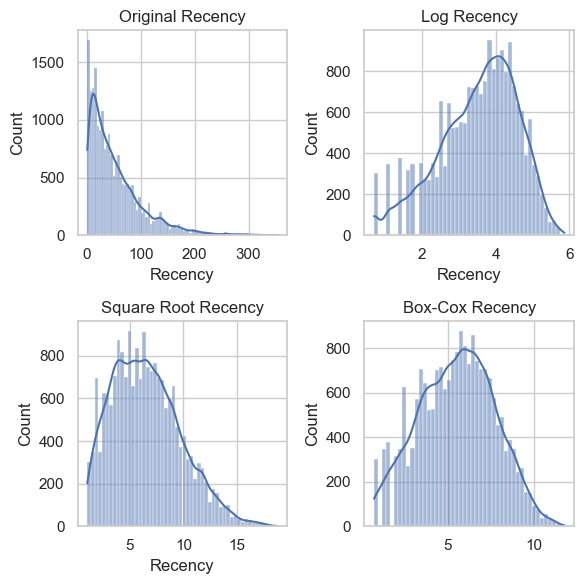

Original : 1.64
Log Transform : -0.54
Square Root Transform : 0.53
Box-Cox Transform : -0.05


In [688]:
# rfm should be your dataframe containing the RFM analysis
analyze_skewness(RFM_columns,'Recency')  

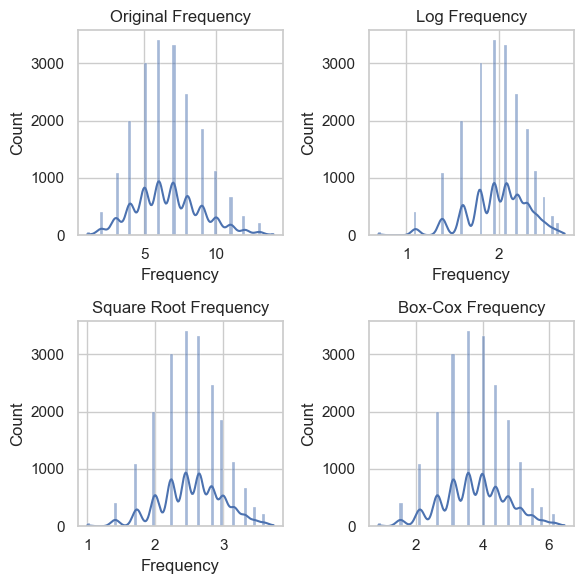

Original : 0.35
Log Transform : -0.55
Square Root Transform : -0.16
Box-Cox Transform : -0.01


In [689]:
analyze_skewness(RFM_columns,'Frequency')  

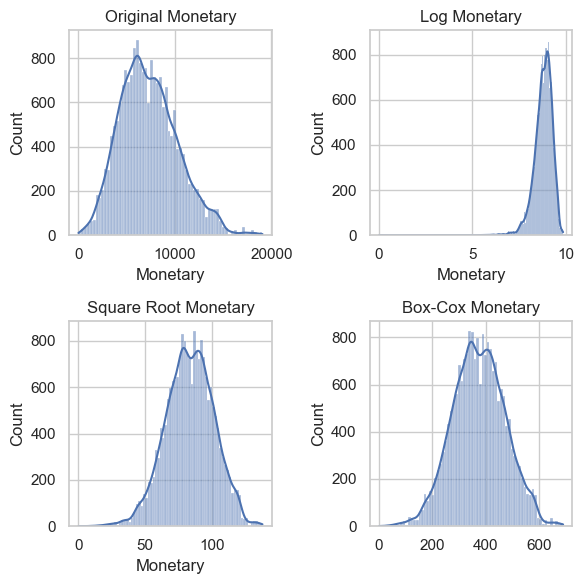

Original : 0.48
Log Transform : -1.51
Square Root Transform : -0.17
Box-Cox Transform : -0.0


In [690]:
analyze_skewness(RFM_columns, 'Monetary')

# Recency:
- Original Skewness: The Recency data initially had a skewness of 1.64, indicating a distribution with a long tail to the right.
- Log Transformation: Skewness changed to -0.54, indicating an over-adjustment with the transformation leading to a distribution skewed to the left.
- Square Root Transformation: Skewness adjusted to 0.53, reducing the right skew but still not completely symmetrical.
- Box-Cox Transformation: Skewness reached -0.05, showing that this method effectively made the distribution almost perfectly symmetrical, with a very slight left skew.

# Frequency:
- Original Skewness: The Frequency data had a moderate right skew with a skewness of 0.35.
- Log Transformation: Skewness changed to -0.55, indicating an over-correction to the left.
- Square Root Transformation: Skewness improved to -0.16, showing a slight left skew.
- Box-Cox Transformation: Skewness was the closest to zero at -0.01, suggesting that this method produced a nearly symmetrical distribution for Frequency.

# Monetary:
- Original Skewness: The Monetary data had a skewness of 0.48, indicating a moderate right skew.
- Log Transformation: Skewness drastically shifted to -1.51, which is an over-correction to the left.
- Square Root Transformation: Skewness was -0.17, slightly left-skewed.
- Box-Cox Transformation: Skewness was 0.00, indicating a perfectly symmetrical distribution, the most desired outcome for many analyses.

In [691]:
# Set the Numbers
from scipy import stats
RFM_Kmeans = pd.DataFrame()
RFM_Kmeans["Recency"] = stats.boxcox(RFM_columns['Recency'])[0]
RFM_Kmeans["Frequency"] = stats.boxcox(RFM_columns['Frequency'])[0]
RFM_Kmeans["Monetary"] = pd.Series(np.cbrt(RFM_columns['Monetary'])).values
RFM_Kmeans.describe()

,Recency,Frequency,Monetary
count,19968.000000,19968.000000,19968.000000
mean,5.920394,3.610262,19.013422
std,2.614855,1.186596,2.819164
min,0.000000,0.000000,0.000000
25%,4.016401,2.806755,17.232223
50%,6.029561,3.853079,19.145285
75%,7.823781,4.334610,20.955955
max,13.479385,6.863886,26.717363


In [692]:
#Scaling the data
scaler = StandardScaler()

scaler.fit(RFM_Kmeans)

# Store for clustering
RFM_normalized = scaler.transform(RFM_Kmeans)

In [693]:
# Assert that it has mean 0 and variance 1
print(RFM_normalized.mean(axis = 0).round(2)) 
print(RFM_normalized.std(axis = 0).round(2)) 

[ 0. -0.  0.]
[1. 1. 1.]


In [694]:
# Create a pandas DataFrame
RFM_normalized = pd.DataFrame(data=RFM_normalized, index=RFM_columns.index, columns=RFM_columns.columns)


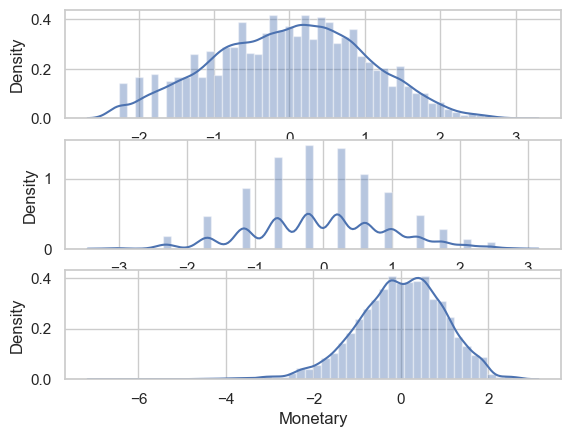

In [695]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(RFM_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(RFM_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(RFM_normalized['Monetary'])

# Show the plot
plt.show()


# Running K-means

To segment the data effectively, we can employ the K-Means algorithm.

The K-Means algorithm is a type of unsupervised machine learning that employs geometric principles to assign data points to clusters. It operates by identifying the centroids—the central points of each cluster—and then computes the distance of each data point to these centroids. A data point is assigned to the cluster of the nearest centroid based on the smallest distance compared to others. This process iterates, adjusting the centroids and reassigning data points until the variation in the sum of distances within clusters reaches a minimal or no significant change.

# Identifying the Optimal Number of Clusters (K)
For our clustering to be most effective, it's crucial to select the optimal hyperparameter that suits our data. The elbow method is a widely used technique to ascertain the best hyperparameter for our model. This approach involves plotting the variation within clusters against different values of K and looking for a 'knee' in the curve, which usually indicates the appropriate number of clusters for our data.

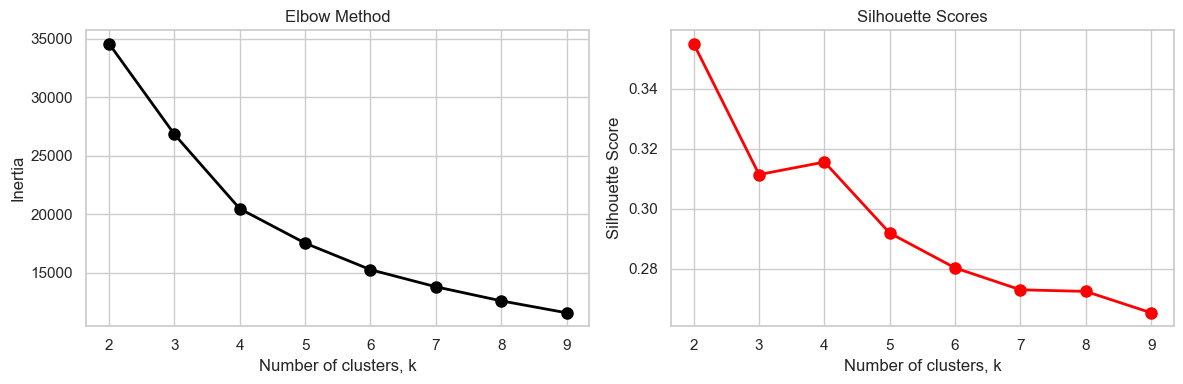

In [696]:
# Range of clusters to try
K = range(2, 10)

# Variables to hold the results
inertias = []
silhouette_scores = []

# Loop over each k value, fit the model and calculate scores
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_normalized)
    
    # Append the inertia to the list
    inertias.append(kmeans.inertia_)
    
    # Compute the silhouette score and append it to the list
    silhouette_avg = silhouette_score(RFM_normalized, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the results
# Set up the matplotlib figure
plt.figure(figsize=(12, 4))

# First subplot for the elbow method
plt.subplot(1, 2, 1)
plt.plot(K, inertias, '-o', color='black', linewidth=2, markersize=8)
plt.title('Elbow Method')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')

# Second subplot for the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, '-o', color='red', linewidth=2, markersize=8)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')

# Show the plots
plt.tight_layout()
plt.show()

# Elbow Method Plot:
- The Elbow Method plot (on the left) displays the inertia (within-cluster sum of squares) for different values of k. 
- Inertia measures how internally coherent clusters are, and it decreases as k increases. The 'elbow' of the plot is where the rate of decrease sharply changes, which can be seen around k=3 or k=4.
- This suggests that increasing the number of clusters beyond this range results in diminishing returns in terms of additional cluster coherence.

# Silhouette Score Plot:
- The Silhouette Score plot (on the right) measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
- The silhouette score ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- From the plot, the highest silhouette score occurs at k=2, suggesting that the data is most distinctly partitioned into two clusters.
- However, there's a notable peak at k=4 as well, which could be considered for clustering given that it has a relatively high score and it's close to the 'elbow' in the inertia plot.

The optimal number of clusters for K-Means, based on the Elbow Method and Silhouette Scores, could be 3 or 4, with 2 also being a contender due to its high silhouette score. While 2 clusters offer clear separation, 4 clusters may reveal more detailed data patterns.

In [697]:
# Apply K-Means with k=4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(RFM_normalized)

# Assign the cluster labels to the DataFrame
RFM_cluster['Cluster'] = kmeans.labels_

In [698]:
RFM_cluster.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM Segment,RFM Scores,Customer_group,Cluster
0,2950,76,3,1953.15,1,1,1,111,3,Low Value,1
1,3120,21,7,7351.70,3,2,3,323,8,Medium Value,0
2,402,57,6,8148.22,2,2,3,223,7,Medium Value,2
3,3135,122,7,7539.81,1,2,3,123,6,Low Value,2
4,787,76,10,11292.54,1,4,4,144,9,High Value,3


In [699]:
# Calculate the counts for each cluster
cluster_counts = RFM_cluster['Cluster'].value_counts().sort_index()

# Calculate the percentage of each cluster
RFM_cluster['Percentage'] = RFM_cluster['Cluster'].map(cluster_counts) / len(RFM_cluster) * 100

# Round to two decimal places and add '%'
RFM_cluster['Percentage'] = RFM_cluster['Percentage'].round(2).astype(str) + '%'

# Now aggregate the data to include the new 'Percentage' column
cluster_summary = RFM_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Percentage': 'first'  # since all values per cluster are the same, we can use 'first'
}).rename(columns={
    'Recency': 'Recency_Mean',
    'Frequency': 'Frequency_Mean',
    'Monetary': 'Monetary_Mean'
}).reset_index()

# Display the result
cluster_summary

,Cluster,Recency_Mean,Frequency_Mean,Monetary_Mean,Percentage
0,0,15.914528,5.677980,5845.169696,24.2%
1,1,99.971764,3.756500,3684.650042,17.91%
2,2,78.452046,6.749091,7553.458854,31.7%
3,3,24.095220,9.477629,10874.169499,26.19%


# Cluster 0: 
This cluster has the lowest average recency of about 16 days, which means customers in this cluster made their most recent purchases quite recently. They have a moderate average frequency of roughly 5.68 purchases, and their average monetary value is around 5845.17 units. They constitute 24.2% of the customer base, indicating they are a significant segment that engages frequently and recently with relatively high spending.

# Cluster 1: 
Customers in this cluster have the highest average recency of approximately 100 days, indicating they are the least recent purchasers compared to other clusters. They also have the lowest frequency with an average of 3.76 purchases and spend less with an average monetary value of 3684.65 units. This group forms 17.91% of the customer base, making them a smaller segment of less engaged, more distant customers with lower spending.

# Cluster 2:
This cluster's customers have an average recency of around 78 days and a frequency of approximately 6.75 purchases, suggesting they are somewhat recent customers with a higher-than-average purchase frequency. They have the second-highest monetary value at 7553.46 units on average. This is the largest cluster, making up 31.7% of the customer base, indicating a significant portion of customers with relatively recent engagement and high spending.

# Cluster 3:
Customers in this cluster are quite recent with an average recency of about 24 days and have the highest purchase frequency at about 9.48 purchases. They also spend the most, with an average monetary value of 10874.17 units. This cluster represents 26.19% of the customer base, highlighting a substantial segment of customers who are very recent, frequent purchasers with the highest spending.

# Conclusion:
- In conclusion, Cluster 0 and Cluster 3 are the most engaged in terms of recency and frequency.
- Cluster 3 stands out as the big spenders and most frequent shoppers.
- Cluster 1 appears to be the least engaged and lowest spenders, potentially at risk for churn.
- Cluster 2, while not the most recent, still maintains a healthy purchase frequency and spending, indicating a loyal customer base.
- Each cluster reflects different customer behaviors and spending patterns, which can be used to tailor specific marketing strategies to enhance customer engagement and increase sales. 

# Snake Plot

In [700]:
# Snake plot to understand and compare segments
RFM_normalized.head()

,Recency,Frequency,Monetary
0,0.743035,-1.701776,-2.310448
1,-0.511269,0.204638,0.152900
2,0.426099,-0.222864,0.393509
3,1.317276,0.204638,0.211234
4,0.743035,1.370635,1.213798


In [701]:
RFM_normalized['customer_id'] = RFM_cluster.index
RFM_normalized['Cluster'] = kmeans.labels_
RFM_normalized.head()

,Recency,Frequency,Monetary,customer_id,Cluster
0,0.743035,-1.701776,-2.310448,0,1
1,-0.511269,0.204638,0.152900,1,0
2,0.426099,-0.222864,0.393509,2,2
3,1.317276,0.204638,0.211234,3,2
4,0.743035,1.370635,1.213798,4,3


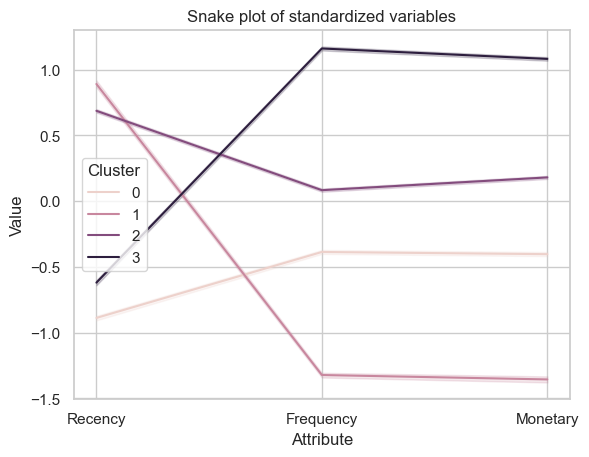

In [702]:
# Melt the data into a long format
RFM_melt = pd.melt(RFM_normalized.reset_index(),
                   id_vars=['customer_id', 'Cluster'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Attribute',
                   value_name='Value')

# Plot the snake plot
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=RFM_melt)
plt.show()

# Cluster 0 - 'New Customers': 
These are customers with recent purchases but low frequency and spend, indicating they are newcomers.
# Cluster 1 - 'Churned Customers': 
This cluster represents individuals who have not made recent purchases, do so infrequently, and spend the least, suggesting they have disengaged.
# Cluster 2 - 'At-Risk Customers': 
Customers in this group, although not recent, have shown higher purchasing frequency and spend, suggesting they were once loyal but may be losing interest.
# Cluster 3 - 'Loyal Customers': 
Exhibiting high scores across all RFM metrics, these customers are recent, frequent, and high spenders, indicating strong loyalty and engagement with the brand.

# Strategy

# Cluster 0 - 'New Customers'
Objective: Encourage repeat purchases and brand loyalty.
Strategies:
- Welcome campaigns with personalized messages to create a connection.
- Introductory offers on the next purchase to encourage a second buy.
- Onboarding emails or tutorials about products or services to engage them.
- Feedback surveys after initial purchase to improve their experience.

# Cluster 1 - 'Churned Customers'
Objective: Re-engage and reactivate their interest in the brand.
Strategies:
- Re-engagement campaigns offering special discounts or loyalty points for their return.
- Reminder communications highlighting what’s new since their last purchase.
- Personalized win-back offers based on their previous purchase history.
- Exit surveys for churned customers to understand their reasons for leaving.

# Cluster 2 - 'At-Risk Customers'
Objective: Rekindle the relationship and prevent further disengagement.
Strategies:
- Loyalty programs to incentivize repeat business.
- Exclusive previews or early access to new products to make them feel valued.
- Personalized recommendations based on past purchases.
- Re-engagement campaigns reminding them of the brand’s value proposition.

# Cluster 3 - 'Loyal Customers'
Objective: Strengthen relationships and encourage advocacy.
Strategies:
- Exclusive VIP or loyalty club memberships with additional benefits.
- Referral programs that reward them for bringing in new customers.
- Personalized communications and offers, such as birthday discounts.
- Opportunities for feedback and involvement in product development to make them feel part of the brand family.